# Spotify Analysis: Predicting Song Popularity

## 1 Introduction

Streaming services like Spotify provide consumers with easy access to the latest music. In this project, we used a database collected using the Spotify API, which contains information on the mode, genres, acousticness, danceability, duration, energy, instrumentalness, liveness, speechiness, tempo, valance, and key of over 600,000 tracks. Attached to each genre is their popularity score based on total plays and recency. Our goal is to investigate ways to predict a song's popularity using the song’s attributes. We will be investigating the following research questions: 

<div align="center"><strong>Can we predict if a particular song is likely to be popular?<strong></div>

<div align="center"><strong>If so, which features can best determine a song's popularity?<strong></div>

## 2 Preliminary Exploratory Data Analysis
### 2.1 Running Necessary Packages

In [2]:
library(tidyverse) #basic data wrangling
library(tidymodels) #general models
library(GGally) #ggpairs multivariate analysis

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### 2.2 Reading and Tidying Data

In [3]:
options(scipen = 999)

genre_data = read_csv("https://raw.githubusercontent.com/paulh777/dsci100prj/main/proposal/data_by_genres.csv")

#Select the columns relevant to research
popularity_data = genre_data %>%
    mutate(mode = as_factor(mode))%>%
    mutate(key = as_factor(key))%>%
    mutate(genres = as_factor(genres))

#Table Preview
popularity_data %>% head(10) 

#Check for NA values
which(is.na(popularity_data))
#No NA rows found

Parsed with column specification:
cols(
  mode = col_double(),
  genres = col_character(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  liveness = col_double(),
  loudness = col_double(),
  speechiness = col_double(),
  tempo = col_double(),
  valence = col_double(),
  popularity = col_double(),
  key = col_double()
)



mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,21st century classical,0.9793333,0.1628833,160297.7,0.07131667,0.606833670,0.36160000,-31.514333,0.04056667,75.3365,0.1037833,27.83333,6
1,432hz,0.4947800,0.2993333,1048887.3,0.45067833,0.477761667,0.13100000,-16.854000,0.07681667,120.2857,0.2217500,52.50000,5
1,8-bit,0.7620000,0.7120000,115177.0,0.81800000,0.876000000,0.12600000,-9.180000,0.04700000,133.4440,0.9750000,48.00000,7
1,[],0.6514170,0.5290926,232880.9,0.41914607,0.205309190,0.21869585,-12.288965,0.10787156,112.8574,0.5136043,20.85988,7
1,a cappella,0.6765573,0.5389612,190628.5,0.31643357,0.003003441,0.17225414,-12.479387,0.08285144,112.1104,0.4482487,45.82007,7
1,abstract,0.4592100,0.5161667,343196.5,0.44241667,0.849666667,0.11806667,-15.472083,0.04651667,127.8858,0.3073250,43.50000,1
1,abstract beats,0.3421467,0.6230000,229936.2,0.52780000,0.333602612,0.09965333,-7.918000,0.11637333,112.4138,0.4935067,58.93333,10
1,abstract hip hop,0.2438541,0.6945709,231849.2,0.64623464,0.024231263,0.16854292,-7.349328,0.21425770,108.2450,0.5713909,39.79070,2
0,accordeon,0.3230000,0.5880000,164000.0,0.39200000,0.441000000,0.07940000,-14.899000,0.07270000,109.1310,0.7090000,39.00000,2


integer(0)

### 2.3 Initial Split

In [4]:
#Initial Split
popularity_num = popularity_data%>%
    select(-key,-genres,-mode) #Removing categorical variables

popularity_split = initial_split(popularity_num, prop = 0.5, strata = popularity)
popularity_training = training(popularity_split)
popularity_testing = testing(popularity_split)

### 2.4 Exploratory Tables
#### 2.4.1 Summary Table of Quantitative Variables

In [5]:
#Summary Table of Quantitative Variables

#Changing milliseconds to minutes to better fit the table
popularity_num2 = popularity_training%>%
    mutate(duration_min=duration_ms/60000)%>%
    select(-duration_ms)

popularity_max = popularity_num2 %>%
    map_df(max, na.rm=TRUE)

popularity_min = popularity_num2 %>%
    map_df(min, na.rm=TRUE)

popularity_mean = popularity_num2 %>%
    map_df(mean, na.rm=TRUE)

popularity_median = popularity_num2 %>%
    map_df(median, na.rm=TRUE)

popularity_sd = popularity_num2 %>%
    map_df(sd, na.rm=TRUE)

    
popularity_max = popularity_max %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "variable",
        values_to = "max"
    )

popularity_min = popularity_min %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "remove1",
        values_to = "min"
    )

popularity_mean = popularity_mean %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "remove2",
        values_to = "mean"
    )

popularity_median = popularity_median %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "remove3",
        values_to = "median"
    )

popularity_sd = popularity_sd %>%
    pivot_longer(
        cols = acousticness:duration_min,
        names_to = "remove4",
        values_to = "standard_deviation"
    )


popularity_table = popularity_max %>%
    bind_cols(popularity_min)%>%
    bind_cols(popularity_mean)%>%
    bind_cols(popularity_median)%>%
    bind_cols(popularity_sd)%>%
    select(variable,max,min,mean,median,standard_deviation)

popularity_table

variable,max,min,mean,median,standard_deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acousticness,0.9960000,0.00000348,0.40783493,0.33375570,0.32295444
danceability,0.9290000,0.05690000,0.53307518,0.54288008,0.15373065
energy,0.9946667,0.00100150,0.55257797,0.58989857,0.23816940
instrumentalness,0.9920000,0.00000000,0.21510224,0.08556088,0.26980927
liveness,0.8642500,0.02390000,0.19213998,0.17886120,0.09095803
loudness,-0.2530000,-41.82500000,-10.70272787,-9.37549702,5.53604635
speechiness,0.9200000,0.02510000,0.08167995,0.05893756,0.07552097
tempo,198.0750000,56.43600000,118.52444160,118.43584954,17.30560463
valence,0.9754000,0.00335250,0.48503055,0.48854529,0.20315703


### 2.5 Exploratory Visualizations
#### 2.5.1 Key Barchart by Count and Mode

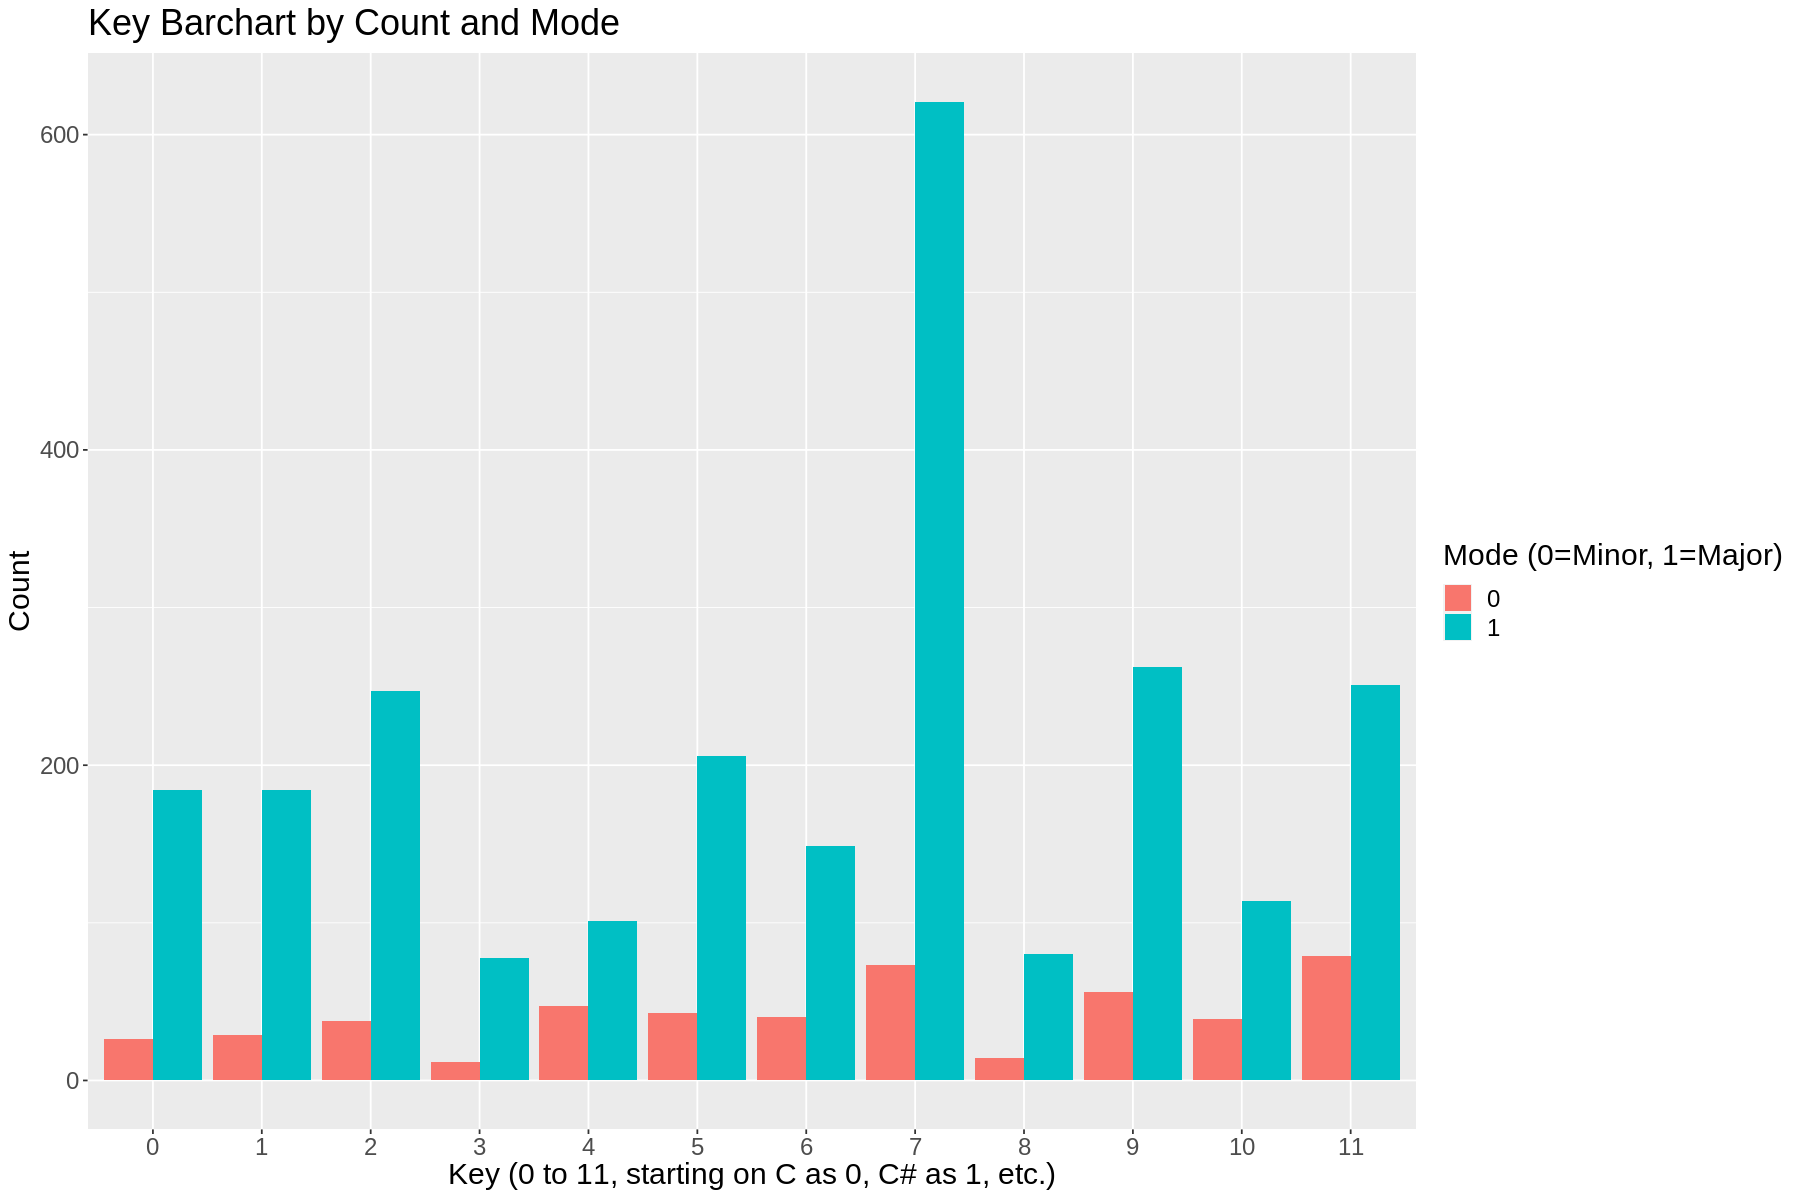

In [6]:
#Key Barchart by Count and Mode

options(repr.plot.width = 15, repr.plot.height = 10)

popularity_cat = popularity_data%>%
    select(mode,key)

key_mode_plot = ggplot(popularity_cat, aes(x=key, fill=mode))+
    geom_bar(position="dodge") + 
    labs(
        x="Key (0 to 11, starting on C as 0, C# as 1, etc.)",
        y="Count", fill="Mode (0=Minor, 1=Major)",
        title="Key Barchart by Count and Mode") +
    theme(text = element_text(size = 18))


key_mode_plot
    

#### 2.5.2 Quantitative Variables vs. Popularity Scatterplots

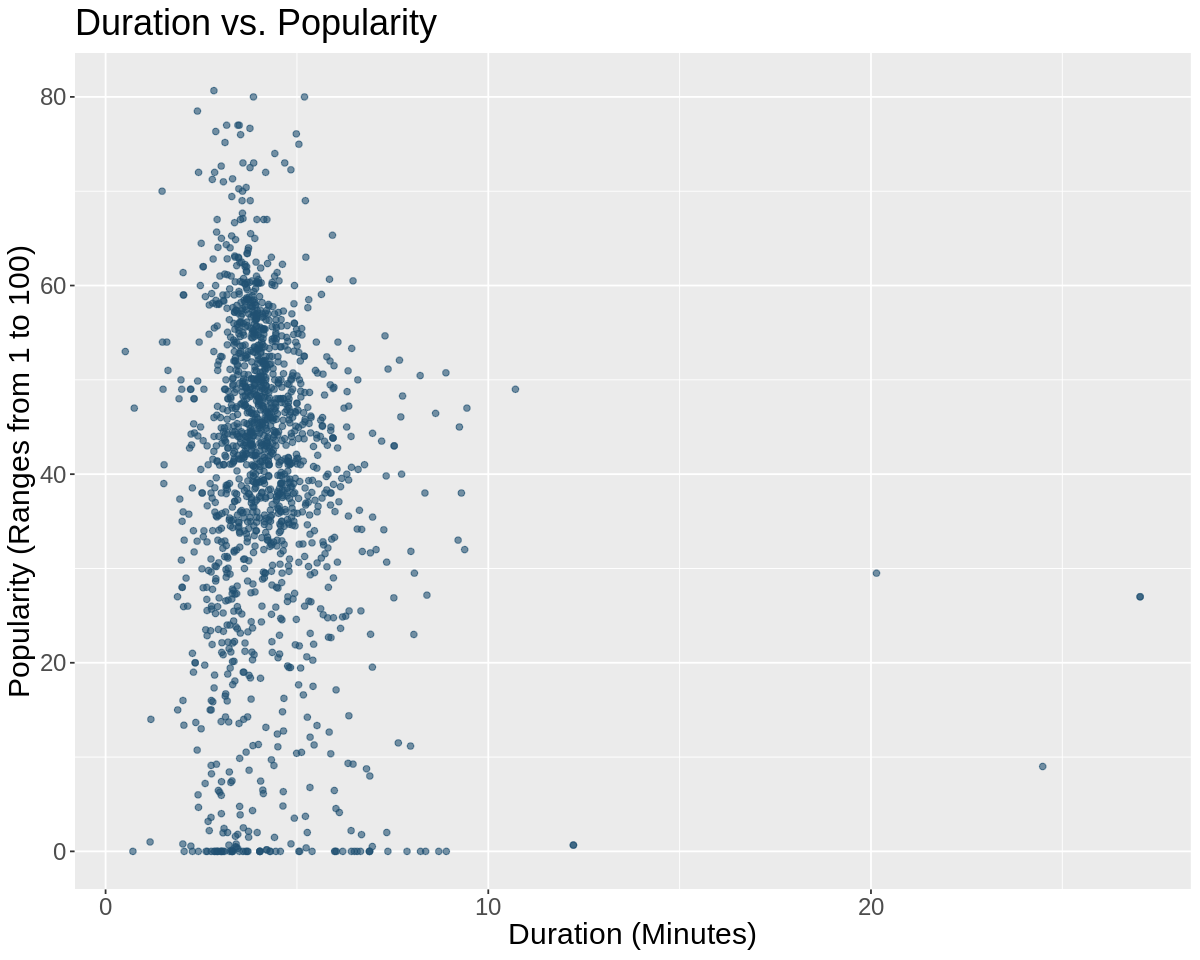

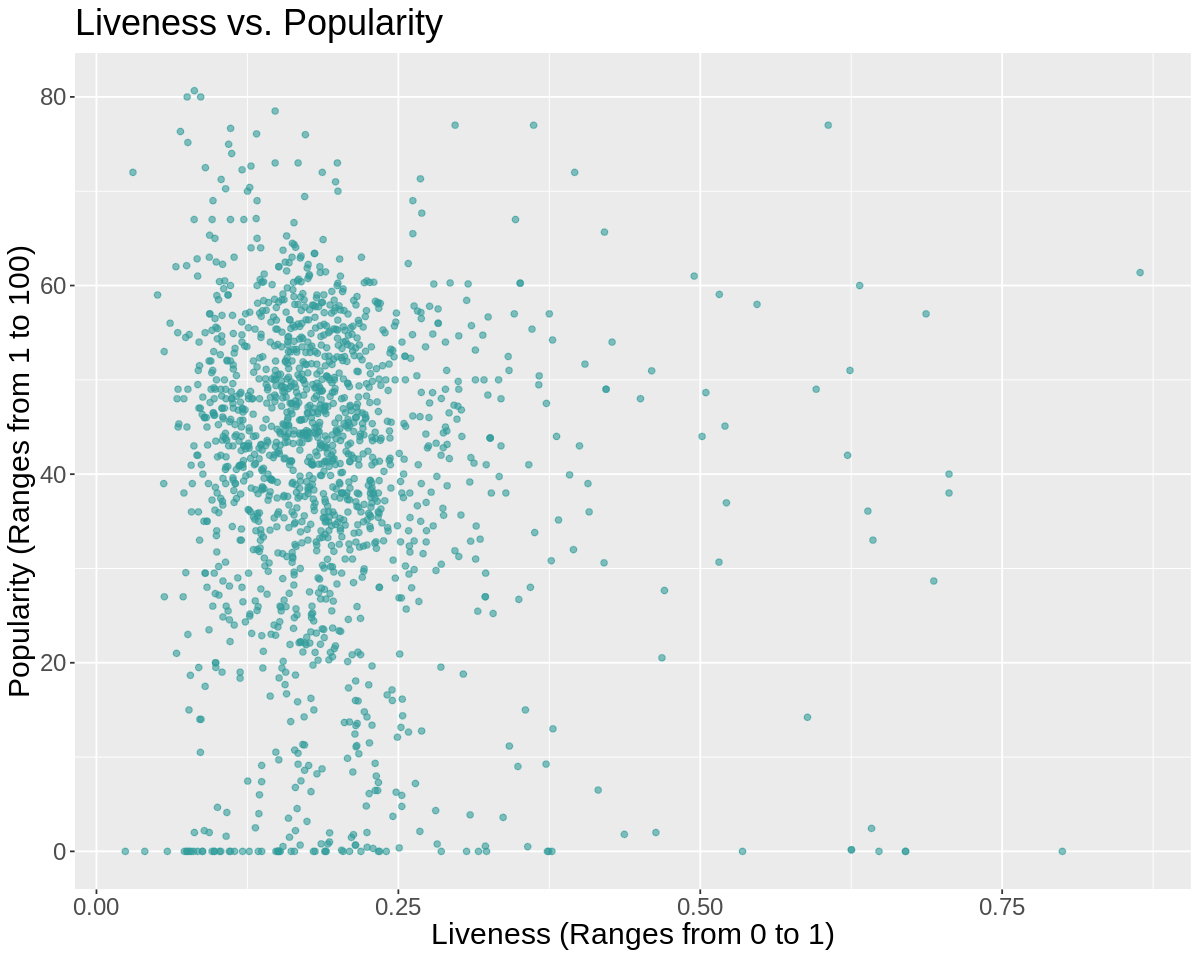

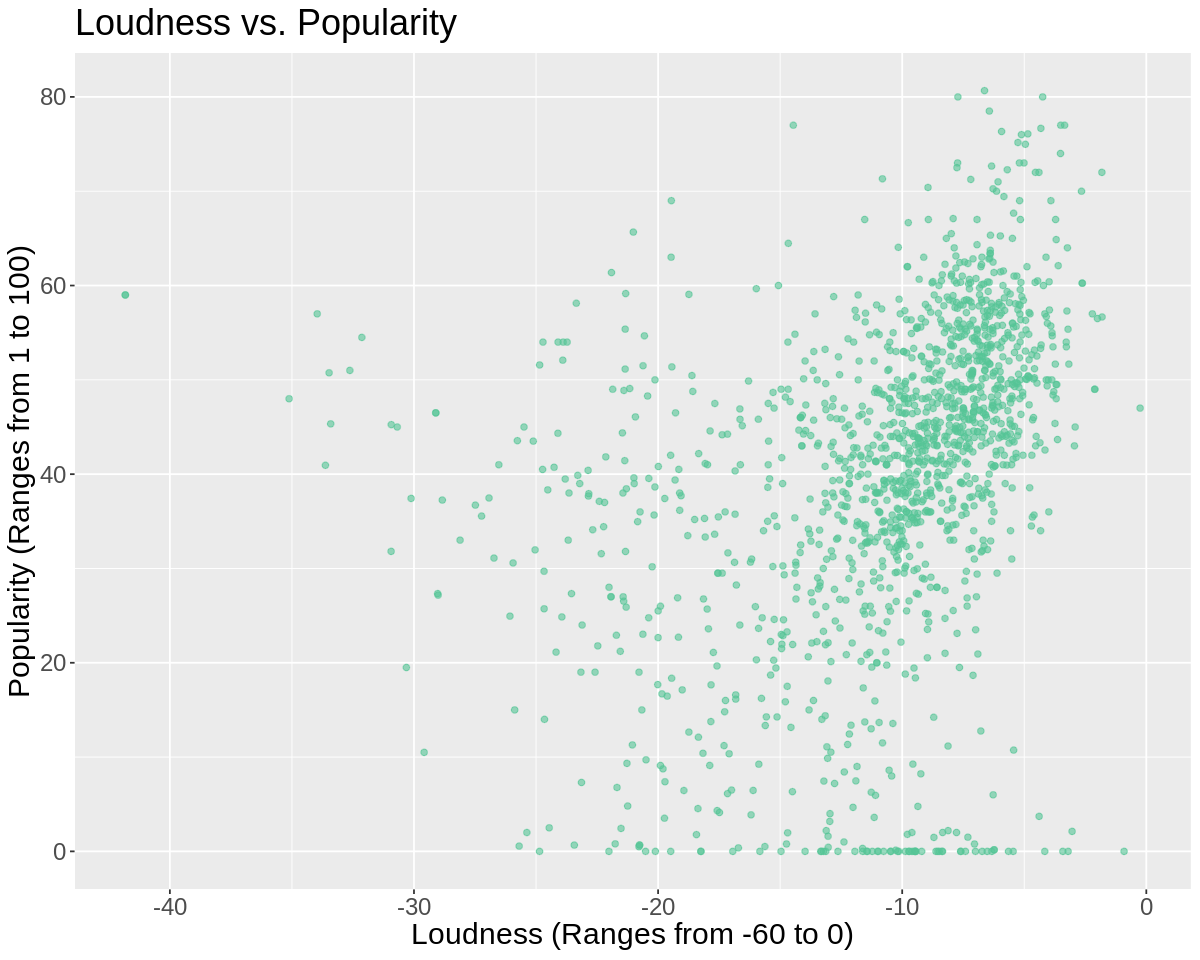

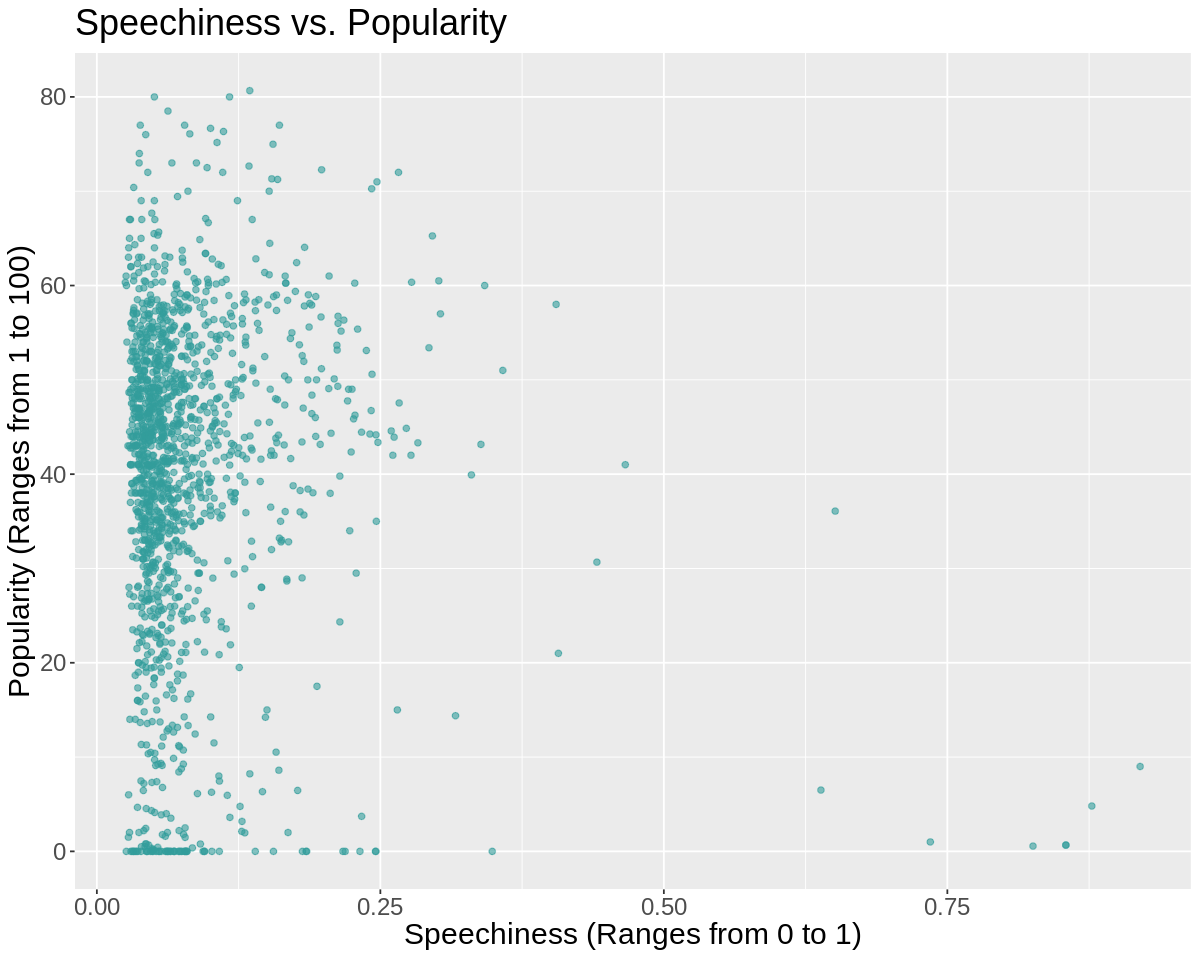

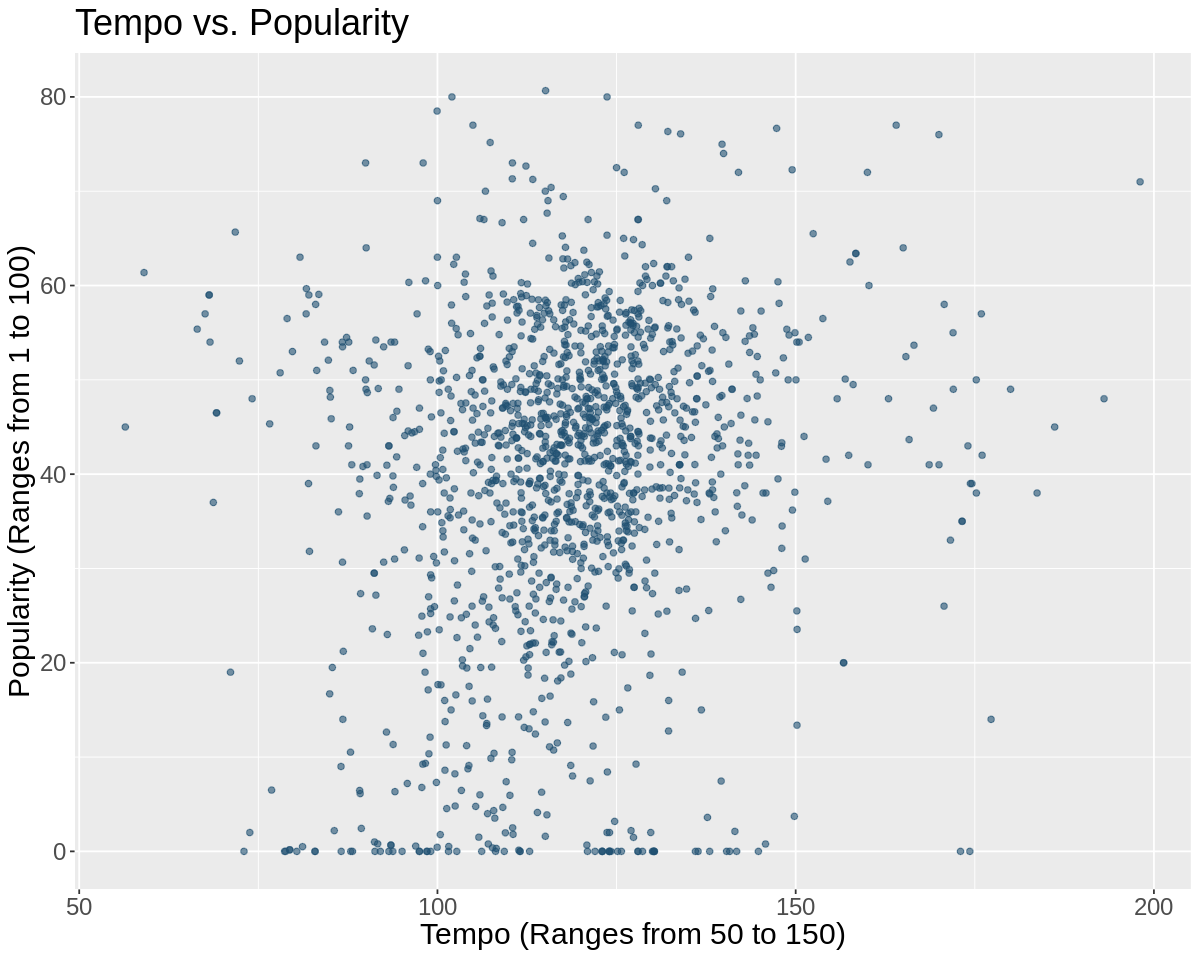

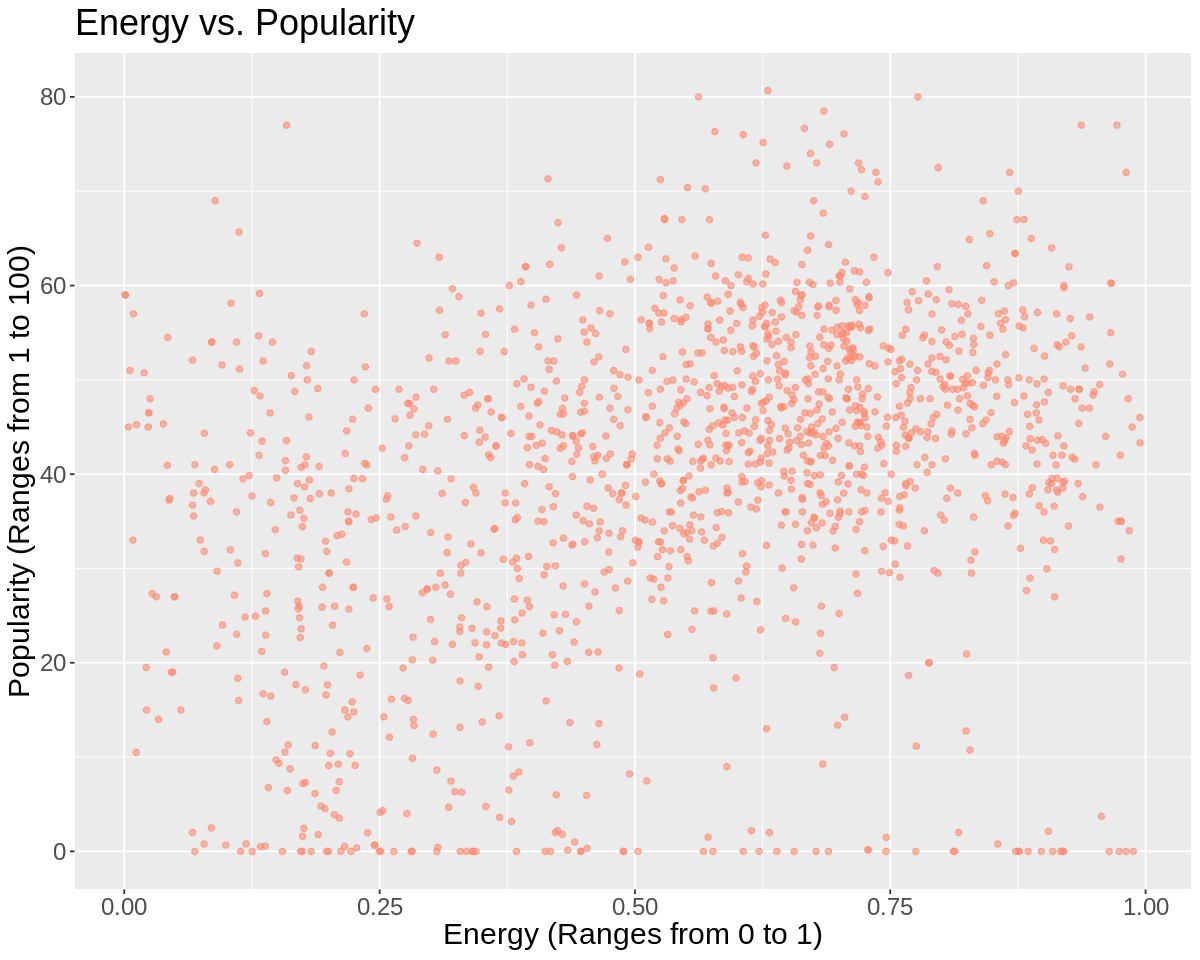

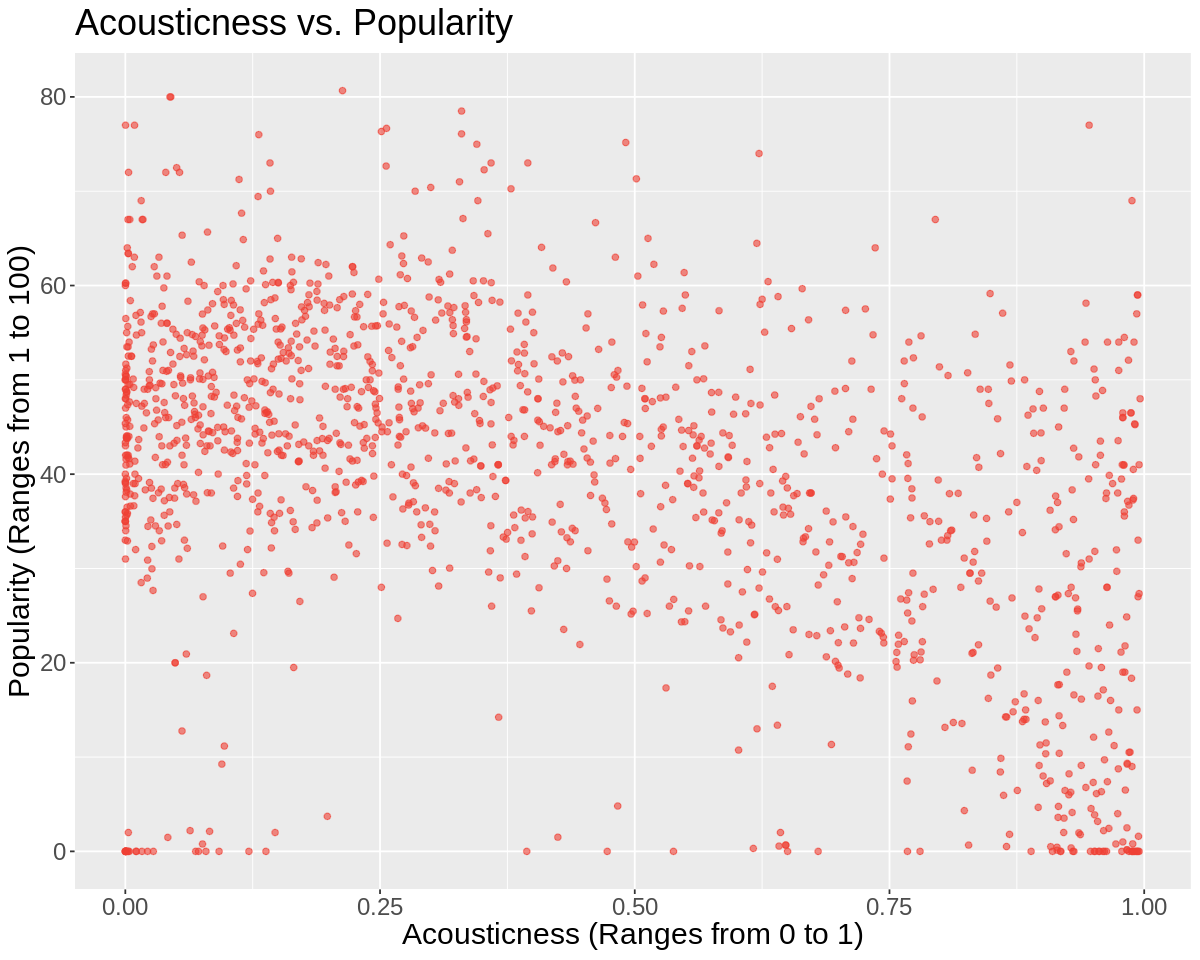

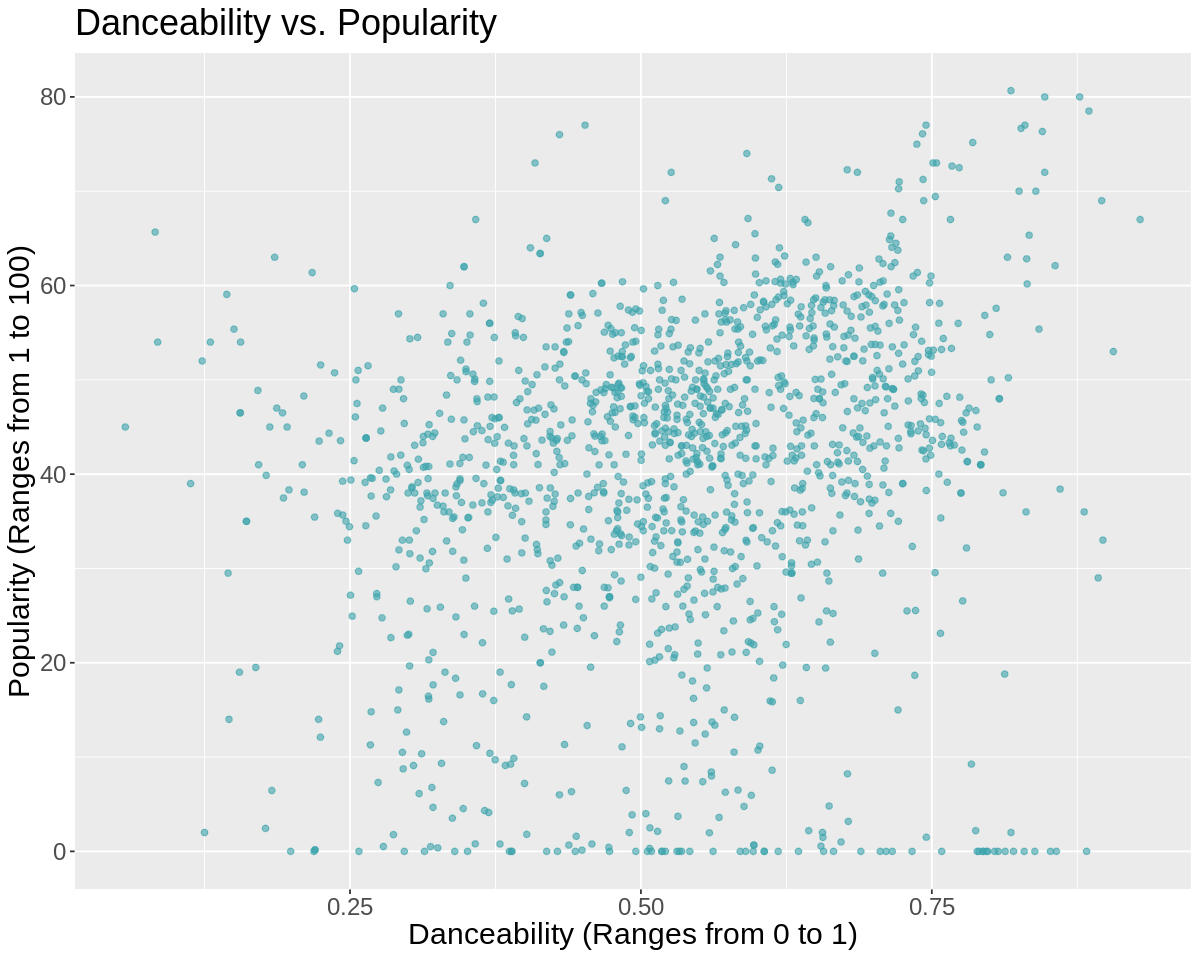

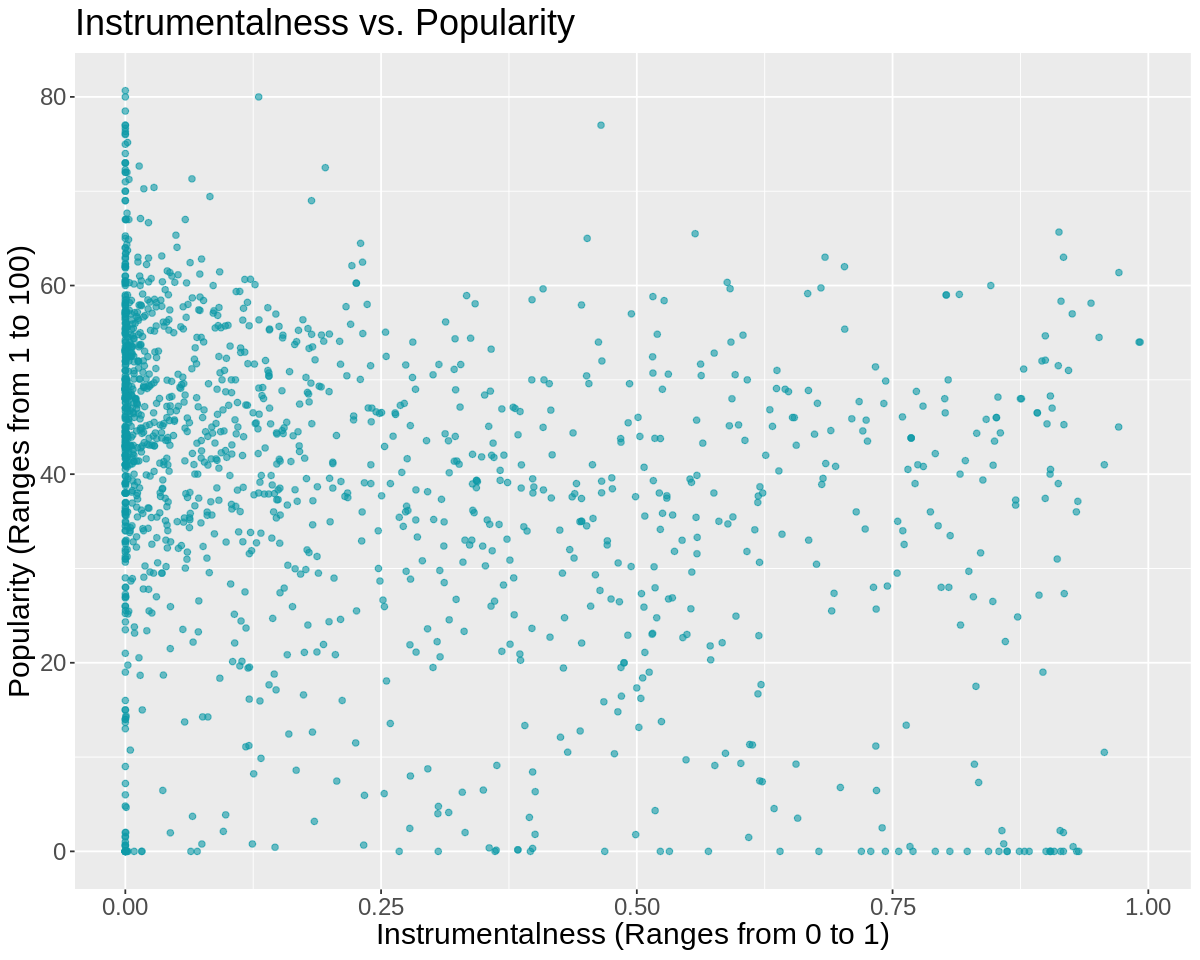

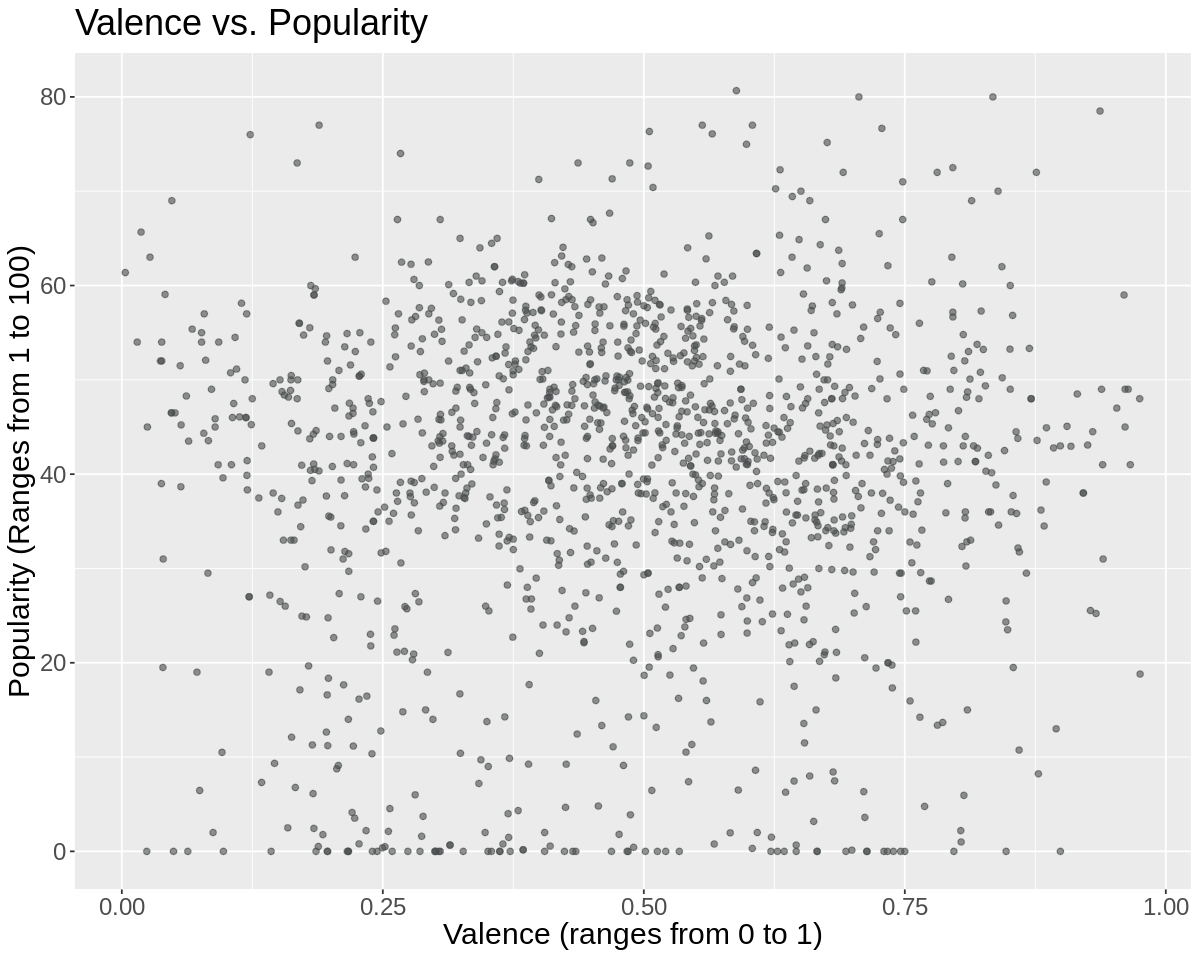

In [7]:
#Visualizations Relevant to Research

options(repr.plot.width=10, repr.plot.height=8)

duration_plot = ggplot(popularity_num2, aes(x = duration_min, y = popularity)) +
    geom_point(alpha=0.6, colour="#205072") +
    labs(
        x="Duration (Minutes)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Duration vs. Popularity"
        ) + theme(text = element_text(size = 18))

duration_plot 

liveness_plot = ggplot(popularity_num2, aes(x = liveness, y = popularity)) +
    geom_point(alpha=0.6, colour="#329D9C") +
    labs(
        x="Liveness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Liveness vs. Popularity"
        ) + theme(text = element_text(size = 18))

liveness_plot

loudness_plot = ggplot(popularity_num2, aes(x = loudness, y = popularity)) +
    geom_point(alpha=0.6, colour="#56C596") +
    labs(
        x="Loudness (Ranges from -60 to 0)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Loudness vs. Popularity"
        ) + theme(text = element_text(size = 18))

loudness_plot

speechiness_plot = ggplot(popularity_num2, aes(x = speechiness, y = popularity)) +
    geom_point(alpha=0.6, colour="#329D9C") +
    labs(
        x="Speechiness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Speechiness vs. Popularity"
        ) + theme(text = element_text(size = 18))

speechiness_plot

tempo_plot = ggplot(popularity_num2, aes(x = tempo, y = popularity)) +
    geom_point(alpha=0.6, colour="#205072") +
    labs(
        x="Tempo (Ranges from 50 to 150)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Tempo vs. Popularity"
        ) + theme(text = element_text(size = 18))

tempo_plot

energy_plot = ggplot(popularity_num2, aes(x = energy, y = popularity)) +
    geom_point(alpha=0.6, colour="#fe8a71") +
    labs(
        x="Energy (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Energy vs. Popularity"
        ) + theme(text = element_text(size = 18))

energy_plot

acousticness_plot = ggplot(popularity_num2, aes(x = acousticness, y = popularity)) +
    geom_point(alpha=0.6, colour="#ee4035") +
    labs(
        x="Acousticness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Acousticness vs. Popularity"
        ) + theme(text = element_text(size = 18))

acousticness_plot

danceability_plot = ggplot(popularity_num2, aes(x = danceability, y = popularity)) +
    geom_point(alpha=0.6, colour="#3da4ab") +
    labs(
        x="Danceability (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Danceability vs. Popularity"
        ) + theme(text = element_text(size = 18))

danceability_plot

instrumentalness_plot = ggplot(popularity_num2, aes(x = instrumentalness, y = popularity)) +
    geom_point(alpha=0.6, colour="#0e9aa7") +
    labs(
        x="Instrumentalness (Ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Instrumentalness vs. Popularity"
        ) + theme(text = element_text(size = 18))

instrumentalness_plot

valence_plot = ggplot(popularity_num2, aes(x = valence, y = popularity)) +
    geom_point(alpha=0.6, colour="#4a4e4d") +
    labs(
        x="Valence (ranges from 0 to 1)",
        y= "Popularity (Ranges from 1 to 100)",
        title= "Valence vs. Popularity"
        ) + theme(text = element_text(size = 18))

valence_plot

#### 2.5.3 Ggpairs Multivariate Analysis

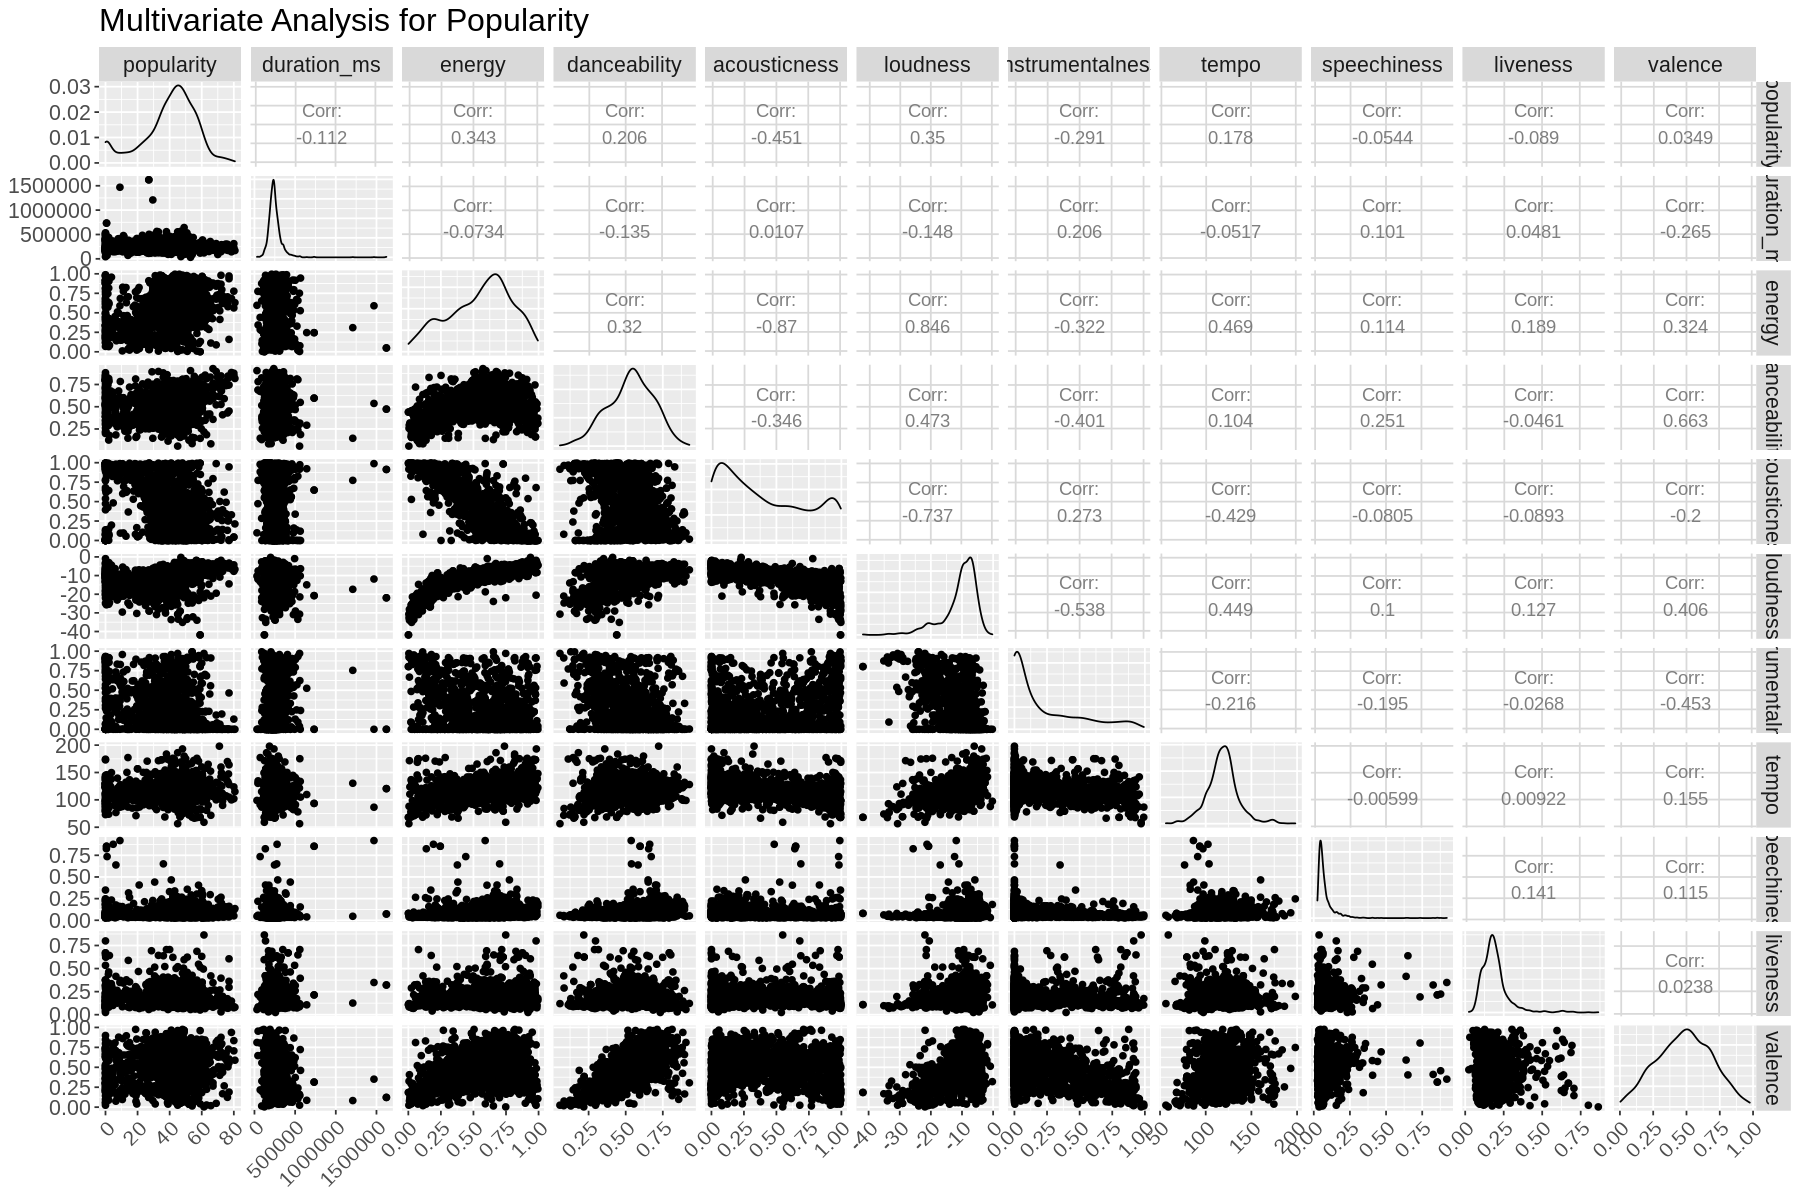

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)

#GGpairs Plot
pair_plot = popularity_training %>%
    select(popularity, duration_ms, energy, danceability, acousticness, loudness, instrumentalness, tempo, speechiness,liveness, valence) %>%
    ggpairs() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    theme(text = element_text(size = 16)) + 
    ggtitle("Multivariate Analysis for Popularity")

pair_plot

In [9]:
set.seed(4002)

popularity_recipe = recipe(popularity ~ energy + acousticness + loudness, data = popularity_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

pop_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

pop_vfold = vfold_cv(popularity_training, v = 5, strata = popularity)

pop_wkflw = workflow() %>%
    add_recipe(popularity_recipe) %>%
    add_model(pop_spec)

pop_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [10]:
set.seed(4002)
gridvals = tibble(neighbors = seq(1,200))

pop_results = pop_wkflw %>%
    tune_grid(resamples = pop_vfold, grid = gridvals) %>%
    collect_metrics()
pop_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,16.5468812,5,0.57182564,Model001
1,rsq,standard,0.2370907,5,0.03398465,Model001
2,rmse,standard,14.9734120,5,0.48040355,Model002
2,rsq,standard,0.2852252,5,0.02926220,Model002
3,rmse,standard,14.3425385,5,0.47544314,Model003
3,rsq,standard,0.3083770,5,0.03526532,Model003
4,rmse,standard,13.9456900,5,0.41121504,Model004
4,rsq,standard,0.3301754,5,0.02889652,Model004
5,rmse,standard,13.8227503,5,0.43891165,Model005


In [11]:
pop_min = pop_results %>% 
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1)
pop_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
28,rmse,standard,13.1653,5,0.4545721,Model028


In [12]:
set.seed(4002)
kmin = pop_min %>%
    pull(neighbors)

pop_spec = nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
    set_engine("kknn") %>%
    set_mode("regression")

pop_fit = workflow() %>%
    add_recipe(popularity_recipe) %>%
    add_model(pop_spec) %>%
    fit(data = popularity_training)

pop_summary = pop_fit %>%
    predict(popularity_testing) %>%
    bind_cols(popularity_testing) %>%
    metrics(truth = popularity, estimate = .pred)

pop_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,13.5058325
rsq,standard,0.3555467
mae,standard,9.5675628


## 3 Methods
### 3.1 Data Wrangling

Wrangling and tidying is a necessary first step to all data analysis procedures. From the raw dataset imported, we manually sorted through them to find 3 categorical and 11 quantitative variables (See 2.2 for details). Although k-nearest neighbors classification and regression only predicts quantitative inputs, we believe it is still worthwhile to explore the categorical variables within the preliminary analysis to discover potential trends relevant to the final discussion (See 2.5.1 for an example). 

### 3.2 Variable selection and Analysis

Regarding the selection of the quantitative variables, the objective of a regression model is not to perfectly replicate real life with an unbounded set of variables, but to predict outcomes using carefully-selected, *impactful variables*.

*“Everything should be made as simple as possible, but not simpler”*
-Albert Einstein

To screen for key variables, each quantitative variable is passed through a multivariate analysis plot from ggpairs() against popularity (See 2.5.4 for details). This method allows us to compare the correlation coefficients -- determining the relevance of each variable. From the current analysis in section 2.5.4, Energy, acousticness, and loudness have the highest correlation to popularity. Furthermore, we plan to implement multiple trials of 5-fold cross validation while tuning the neighbors in the final analysis to assess other variables' potential impact on a song’s popularity.

Finally, because the dataset has 2,973 observations, we confidently chose a 50/50 split  because a reasonably large dataset allows for more observations to be dedicated to testing without compromising accuracy from the training side.


### 3.3 Visualization of Results 

The regression analysis described previously can have two potential visualizations. Of these two, the standard is an underfitting vs overfitting plot to show the optimal K selection. For the complex visualization, we plan to plot our KNN regression line for each variable individually against popularity to compare the accuracy of each variable, since no methods exist that allow us to plot on 2+ dimensions.

## 4 Conclusion

By following the methods outlined above, we intend to create a model that is capable of determining a song's expected popularity before its release, which could have real-world applications in the music industry. Building upon this analysis, we can also investigate how song features change based on demographics and how popularity relates to non-musical factors such as investment and marketing. 